In [53]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from joblib import dump
from matplotlib import pyplot as plt


In [8]:
dataX = np.loadtxt("../preprocessed_data/dataX.csv", delimiter=",")
dataY = np.loadtxt("../preprocessed_data/dataY.csv", delimiter=",")


In [9]:
scaler = StandardScaler()

scaledDataX = scaler.fit_transform(dataX)

dump(scaler, "std_scaler.joblib")


['std_scaler.joblib']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(scaledDataX, dataY, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((2412, 13), (603, 13), (2412,), (603,))

In [44]:
class SensorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, ix):
        x = self.X[ix]
        y = self.y[ix]
        return x, y
    
    def get_all(self):
        return self.X, self.y
    
train_set = SensorDataset(X_train, y_train)
test_set = SensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hidden1 = 64
hidden2 = 32

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(dataX.shape[1], hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1)
        )

    def forward(self, x):
        return self.layers(x)
    
model = MLP().to(device)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [59]:
epochs = 5
losses = []

model.train()
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    for batch_num, input_data in enumerate(train_loader):
        optimizer.zero_grad()
        x, y = input_data
        x = x.to(device).float()
        y = y.to(device).float().view(-1, 1)

        output = model(x)
        
        loss = loss_function(output, y)
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        
        if batch_num % 10 == 0:
            print(f"Loss: {loss.item() ** 0.5}")

        

Epoch 1/5
Loss: 6.649249913641576
Loss: 5.66909595851194
Loss: 5.446302282937379
Loss: 5.1328169591875605
Loss: 4.427547200154361
Loss: 3.434788414714569
Loss: 2.8829512730720435
Loss: 2.380387670214718
Epoch 2/5
Loss: 2.230037614137378
Loss: 1.6600330262173473
Loss: 1.7173093827149182
Loss: 1.6354921975481775
Loss: 1.472793855992255
Loss: 1.4134316064449004
Loss: 1.3342215688791594
Loss: 0.9627984178820117
Epoch 3/5
Loss: 0.9892519077979628
Loss: 1.0480038833473415
Loss: 0.6160878876250695
Loss: 0.8437655765367215
Loss: 1.0206904927700904
Loss: 0.8461809108147084
Loss: 0.9313688061602552
Loss: 0.7257436834987516
Epoch 4/5
Loss: 0.7904451927208268
Loss: 0.732121805393465
Loss: 0.9175508887291172
Loss: 0.6284622141238496
Loss: 0.5133754904990573
Loss: 0.6231338296798428
Loss: 0.9806972404600637
Loss: 0.6842875638176531
Epoch 5/5
Loss: 0.496887248266153
Loss: 0.47771751642308086
Loss: 0.614097465121478
Loss: 0.5158556220128832
Loss: 0.5286352097018543
Loss: 0.5711160251014948
Loss: 0.517

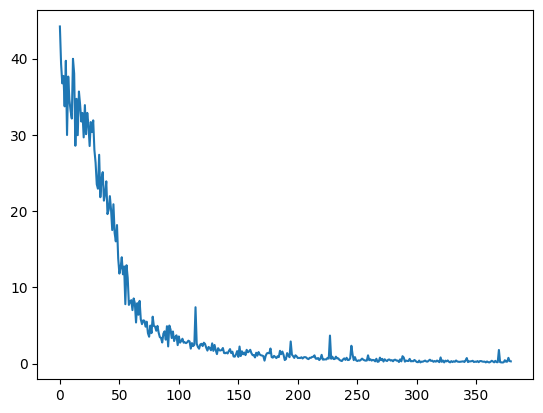

In [60]:
plt.plot(losses)

In [61]:
model.eval()

test_X, test_y = test_set.get_all()

test_predictions = model(test_X)

loss = loss_function(test_predictions, test_y.view(-1, 1))

print(f"Test loss: {loss.item() ** 0.5}")


Test loss: 0.501242821563537
